In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from numpy.linalg import eig
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_iris
from sklearn import datasets
from sklearn.pipeline import Pipeline

In [24]:
# Step 1

#Linear_SVC model
class Linear_SVC:
    
    def __init__(self, C=1, max_iter=100, tol=None, learning_rate="constant",learning_rate_init=0.001, t_0=1, t_1=1000, early_stopping=False, validation_fraction=0.1,**kwargs):
        self.C = C
        self.max_iter = max_iter
        self.tol = tol
        self.learning_rate = learning_rate
        self.learning_rate_init = learning_rate_init
        self.t_0 = t_0
        self.t_1 = t_1
        self.early_stopping = early_stopping
        self.validation_fraction = validation_fraction
        
    def fit(self, X, unscaledX, Y):
        self.X = np.array(X,np.float)
        self.Y = np.array(Y,np.float)
        self.previous_cost = 0
        self.coef_ = np.array([np.zeros(X.shape[1])])
        self.intercept_ = np.array([0.])
        
        for i in range(self.max_iter):
            if self.learning_rate == 'adaptive':
                learnRate = self.t_0/(i + self.t_1)
            else:
                learnRate = self.learning_rate_init

            w_unscaled = self.coef_[0] / np.std(self.X, axis=0)
            b_scaled = self.intercept_

            # Following term is subtracted from the b_scaled
            b_subtract = (self.coef_[0]).T.dot(-np.mean(self.X, axis=0) / np.std(self.X, axis=0))
            b_unscaled = np.array(b_scaled + b_subtract)

            # Update the weight and intercept of the model with the unscaled weight parameters
            self.intercept_ = np.array(b_unscaled)
            self.coef_ = np.array([w_unscaled])

            # The original class labels are 0 and 1.
            # We need to transform them to -1 and 1.
            t = self.Y * 2 - 1

            # Note that the data points are classified according to the following rule:
            #  (t * (X.dot(w) + b) >= 1)
            # Thus the support vectors will satisfy: (t * (X.dot(w) + b) < 1)
            support_vectors_idx = (t * (self.X.dot(w_unscaled) + b_unscaled) < 1).ravel()

            self.support_vectors = unscaledX[support_vectors_idx]
            self.support_vectors_label = self.Y[support_vectors_idx]
            
            # Cost Function
            totalSupportVector = np.sum(1 - (np.dot(self.support_vectors, self.coef_[0])))
            totalBias = self.intercept_ * np.sum(self.support_vectors_label)
            
            self.costFunction = (1/2) * (np.dot(self.coef_.T, self.coef_)) + self.C * (totalSupportVector - totalBias)
            
            if self.tol is not None:
                if (abs(self.previous_cost-np.max(self.costFunction)) < self.tol):
                    break
                    
            #Update Cost/error
            self.previous_cost = np.max(self.costFunction)

            w = self.coef_ - self.C * np.sum(self.support_vectors)
            b = (-self.C) * np.sum(self.support_vectors_label)
            
            self.coef_ = self.coef_ - learnRate * w
            self.intercept_ = self.intercept_ - learnRate * b
    
    def predict(self, x):
        x = np.array(x, np.float)
        y_pred = np.dot(x, self.coef_[0]) + self.intercept_[0]
        return y_pred

In [3]:
# Step 2

data = load_iris()

X = data['data']
y = data['target']
df = pd.DataFrame(np.c_[X,y], columns=data['feature_names']+['target'])

df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [4]:
df = df.drop(columns='sepal length (cm)')
df = df.drop(columns='sepal width (cm)')

# Categorize the target is Iris Virginica (1) or not Iris Virginica (0)
def categorizeQualityData(dataFrame, columnName):
    for i in range(dataFrame.shape[0]):
        if dataFrame[columnName][i] == 2:
            dataFrame[columnName][i] = 1
        else:
            dataFrame[columnName][i] = 0 
    return 

categorizeQualityData(df, 'target')

df.head()

,petal length (cm),petal width (cm),target
0,1.4,0.2,0.0
1,1.4,0.2,0.0
2,1.3,0.2,0.0
3,1.5,0.2,0.0
4,1.4,0.2,0.0


In [5]:
df = df.sample(frac=1) 
df.head()

,petal length (cm),petal width (cm),target
115,5.3,2.3,1.0
86,4.7,1.5,0.0
11,1.6,0.2,0.0
138,4.8,1.8,1.0
65,4.4,1.4,0.0


In [6]:
# Splitting the data into Train Set and Test Set
def partition(X,y,t):
    x_train = np.array(X[int(len(X)*t):])
    x_test = np.array(X[:int(len(X)*t)])
    y_train = np.array(y[int(len(y)*t):])
    y_test = np.array(y[:int(len(y)*t)]) 
    return x_train, x_test, y_train, y_test

#separate the target vector and features
def separateTargetVector(dataSet):
    y = dataSet['target'] #target vector
    X = dataSet.drop(columns='target') #features matrix
    return X,y

#a function to split data into partition
#according to the number of folds
def partitionSplit(df, folds):
    s_partition = []
    dfCopy = df
    #set the size for each partiton
    eachPartition = int(df.shape[0] / folds)
    for i in range(folds):
        partition = []
        #going through each partition
        for j in range(eachPartition):
            if(len(partition) < eachPartition):
                value = dfCopy.index[0]
                partition.append(value.tolist())
                dfCopy = dfCopy.drop(value)
        s_partition.append((np.asarray(partition)).tolist())
  
    return s_partition

#function to standardize the data
def standardizeData(dataSet):
    dfCopy = pd.DataFrame()
    
    for key, values in dataSet.iteritems():
        dfCopy[key] = values

    for key, values in dfCopy.iteritems():
        mean = dfCopy[key].mean()
        std = dfCopy[key].std()
        if key != 'target':
            dfCopy[key] = (dfCopy[key] - mean) / std
    return dfCopy

standardizeData = standardizeData(df)

In [7]:
# Generates the Confusion Matrix
def confusionMatrix(actual, predicted):
    confusionLists = np.unique(actual)
    matrixSize = len(confusionLists)
    matrix = np.zeros((matrixSize, matrixSize))
    for index in range(len(predicted)):
        if (predicted[index] > 1):
            predicted[index] = 1
        else:
            predicted[index] = 0
        
    for i in range (matrixSize):
        for j in range (matrixSize):
            matrix[i, j] = np.sum((actual == confusionLists[i]) & (predicted == confusionLists[j]))
    return matrix

# Generates the accuracy
def accuracy(labels, predictions):
    cnt = 0.0
    for i in range(len(labels)):
        if labels[i] == 1 and predictions[i] > 1:
            cnt += 1.0
        elif labels[i] == 0 and predictions[i] < 1:
            cnt += 1.0
    return cnt/len(labels)

In [13]:
# Step 4

#function for the s-fold validation
def sFold(folds, data, labels, unscaledData, model, error_function, dictionary): 
    avgAccuracy = [] 
    value = []
    splitX = partitionSplit(data, folds)
    splitUnscaledData = partitionSplit(unscaledData, folds)
    minError = 100.0
    
    #loop to choose a partition as validation set
    for i, partition in enumerate(splitX):
        trainSet = list(splitX)
        unscaledTrainSet = list(splitUnscaledData)
        del(trainSet[i])       #dropping the validation set
        del(unscaledTrainSet[i])
        trainSet = sum(trainSet, [])
        unscaledTrainSet = sum(unscaledTrainSet, [])

        testSet = []           #getting the validation set 
        for row in partition:
            testSet.append(row)  #put data in validation set into a new list 
        
        unscaledTestSet = []           #getting the validation set 
        for row in partition:
            unscaledTestSet.append(row)
            
        #splitting the data into train and test set
        xTrainValues = []
        yTrainValues = []    
        unscaledXTrainValues = []
        for trainIndex in trainSet:
            xTrainValues.append(data.loc[trainIndex])
            yTrainValues.append(labels.loc[trainIndex])
            unscaledXTrainValues.append(unscaledData.loc[trainIndex])
            
        #splitting the validation set data into train and test set
        xTestValues = []
        yTestValues = []
        for testIndex in testSet:
            xTestValues.append(data.loc[testIndex])
            yTestValues.append(labels.loc[testIndex])
    
        #preform prediction using Softmax Regression
        if model == 'Linear_SVC':
            modelClassifier = Linear_SVC(C=dictionary.get('C'), max_iter=dictionary.get('max_iter'), tol=dictionary.get('tol'), learning_rate=dictionary.get('learing_rate'),learning_rate_init=dictionary.get('learning_rate_init'), t_0=1, t_1=1000)
            modelClassifier.fit(np.array(xTrainValues), np.array(unscaledXTrainValues), np.array(yTrainValues))
            yPredict= modelClassifier.predict(np.array(xTestValues))

            #calculating the error using mse score
            if error_function == "accuracy":
                accuracy_value = accuracy(np.array(yTestValues), yPredict)
                avgAccuracy.append(accuracy_value)
    
    avgFinalAccuracy = sum(avgAccuracy)/folds
    if(avgFinalAccuracy < minError):
        minError = avgFinalAccuracy

    return minError

#function to pass the hyperparameter into s-fold validation
def dictionary(C, learning_rate, learning_rate_init, max_iter, tol):
    result = []
    model = []
    modelArgs = dict()
    #form the dictionary
    for eachC in C:
        for eachLearningRate in learning_rate:
            for eachLearningRateInit in learning_rate_init:
                for eachMaxIter in max_iter:
                    for eachTol in tol:
                        modelArgs = {'C' : eachC, 'learning_rate' : eachLearningRate, 'learning_rate_init' : eachLearningRateInit,'max_iter': eachMaxIter, 'tol': eachTol}
                        #use of s-folds
                        accuracy = sFold(5, X, y, unscaledX, 'Linear_SVC', 'accuracy', modelArgs)
                        result.append(accuracy)
                        model.append(modelArgs)

    acc = np.array(result)
    best_args = model[acc.argmax()]
    return best_args

#get the X data(features without target) and y data(target column)
X,y = separateTargetVector(standardizeData)
unscaledX, unscaledY = separateTargetVector(df)
C = [1.0, 0.5, 0.1]
learning_rate = ['constant', 'adaptive']
learning_rate_init = [0.001]
max_iter = [100, 1000, 10000]
tol = [0.1, 0.01, 0.001]

best_args = dictionary(C, learning_rate, learning_rate_init, max_iter, tol)
print(best_args)

{'C': 0.1, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 100, 'tol': 0.1}


In [26]:
# Step 5

X,y = separateTargetVector(standardizeData)
xTrain, xTest, yTrain, yTest = partition(X, y, 0.2)
unscaledX, unscaledY = separateTargetVector(df)
unscaledXTrain, unscaledXTest, unscaledYTrain, unscaledYTest = partition(unscaledX, unscaledY, 0.2)
modelClassifier = Linear_SVC(C=0.1, max_iter=100, tol=0.1, learning_rate='constant',learning_rate_init=0.001, t_0=1, t_1=1000, early_stopping=False, validation_fraction=0.1)
modelClassifier.fit(xTrain, unscaledXTrain, yTrain)
yPredict = modelClassifier.predict(xTest)
yPredict = np.array(yPredict)
print('Accuracy:', accuracy(yTest, yPredict))
print('Confusion Matrix:', confusionMatrix(yTest, yPredict))
print("\n")

Accuracy: 0.9666666666666667
Confusion Matrix: [[20.  0.]
 [ 1.  9.]]




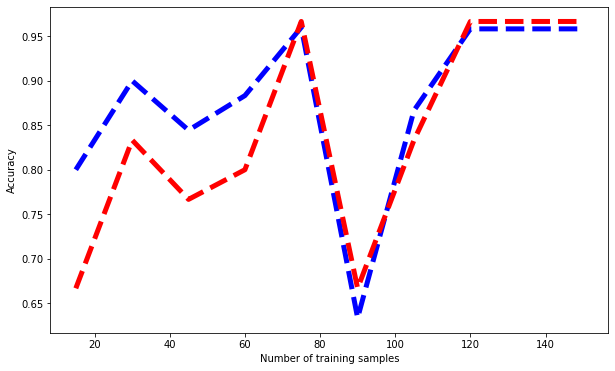

In [16]:
# Step 6

import matplotlib.pyplot as plt
modelClassifier = Linear_SVC(C=0.1, max_iter=100, tol=0.1, learning_rate='constant',learning_rate_init=0.001, t_0=1, t_1=1000, early_stopping=False, validation_fraction=0.1)
trainSizes = np.linspace(0.1, 1.0, 10)*len(X)  
trainSizes = [int(i) for i in trainSizes]
trainAccuracyList = []
testAccuracyList = []
for i in trainSizes:
    modelClassifier.fit(xTrain[:i], unscaledXTrain[:i], yTrain[:i])
    yPredict = modelClassifier.predict(xTrain[:i])
    trainAccuracy = accuracy(yTrain[:i], yPredict)
    trainAccuracyList.append(trainAccuracy)
    yPredict = modelClassifier.predict(xTest)
    testAccuracy = accuracy(yTest, yPredict)
    testAccuracyList.append(testAccuracy)

fig = plt.figure(figsize=(10, 6))
plt.plot(trainSizes, trainAccuracyList, color='blue', linewidth=5, linestyle='--')
plt.plot(trainSizes, testAccuracyList, color='red', linewidth=5, linestyle='--')

plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.show()

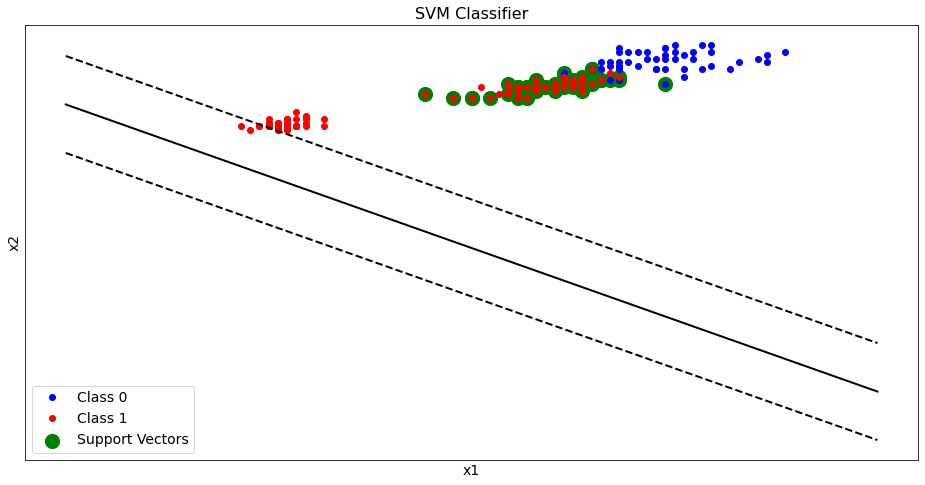

In [19]:
# Step 7

#Plot decision boundary
def decision_boundary_support_vectors(svm_clf, X):
    
    xmin, xmax = X.min() - 1, X.max() + 1
    
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w1*x1 + w2*x2 + b = 0
    # => x2 = -(b + w1* x1)/w1
    x1 = np.linspace(xmin, xmax, 100)

    decision_boundary = -(b + w[0]*x1)/w[1]
    shifting_factor_for_margin = 1/w[1]
    upper_margin = decision_boundary + shifting_factor_for_margin
    lower_margin = decision_boundary - shifting_factor_for_margin
    
    svs = svm_clf.support_vectors
    plt.scatter(svs[:, 0], svs[:, 1], s=200, facecolors='g', label="Support Vectors")
    plt.plot(x1, decision_boundary, "k-", linewidth=2)
    plt.plot(x1, upper_margin, "k--", linewidth=2)
    plt.plot(x1, lower_margin, "k--", linewidth=2)

#Show the support vectors
X,y = separateTargetVector(df)
X = np.array(X)
y = np.array(y)

plt.figure(figsize=(16,8))
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bo", label="Class 0")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "ro", label="Class 1")

decision_boundary_support_vectors(modelClassifier, X)

plt.xlabel("x1", fontsize=14)
plt.ylabel("x2", fontsize=14)
plt.legend(loc="best", fontsize=14)
plt.title("SVM Classifier", fontsize=16)
plt.xticks(())
plt.yticks(())
plt.show()

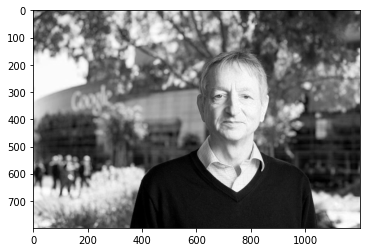

In [20]:
#Step 9

X = plt.imread("Hinton.jpg")[:,:,0]
plt.gray()
plt.imshow(X)

In [21]:
#Step 10

#mean center the data matrix X
X_mean = np.mean(X, axis=0)
print("\nMean of X:\n", X_mean )

#compute the covariance matrix from it
X_centered = X - X_mean
cov_X =  X_centered.T.dot(X_centered)/(X.shape[0]-1)
print("\nCovariance Matrix:\n", cov_X)

#find eigenvalues and eigenvectors of the covariance matrix
eigenvalues, eigenvectors = eig(cov_X)
print("\nEigenvectors (Principle Components):\n", eigenvectors)
print("\nEigenvalues (Variances):\n", eigenvalues)


Mean of X:
 [181.68961202 181.4155194  180.85982478 ... 111.38047559 111.5669587
 111.69461827]

Covariance Matrix:
 [[3516.14915261 3515.75820653 3517.60054705 ... 2319.4753859
  2291.25890446 2275.88253801]
 [3515.75820653 3526.6717388  3543.03701525 ... 2363.40185727
  2337.09119012 2322.34133676]
 [3517.60054705 3543.03701525 3581.76979997 ... 2444.06593141
  2420.07205435 2406.1476156 ]
 ...
 [2319.4753859  2363.40185727 2444.06593141 ... 5382.53174865
  5358.82411598 5332.57372938]
 [2291.25890446 2337.09119012 2420.07205435 ... 5358.82411598
  5345.2458242  5325.62949614]
 [2275.88253801 2322.34133676 2406.1476156  ... 5332.57372938
  5325.62949614 5311.84647476]]

Eigenvectors (Principle Components):
 [[ 2.01894315e-02+0.j         -2.93318095e-02+0.j
   2.88794538e-02+0.j         ... -9.06679688e-03-0.00593254j
  -9.06679688e-03+0.00593254j  7.46773207e-03+0.j        ]
 [ 2.07973851e-02+0.j         -3.00764423e-02+0.j
   2.87869589e-02+0.j         ...  5.91001283e-05+0.0003860

In [22]:
#Step 15

#perform steps 11 – 14 for the following values of k: 10, 30, 50, 100, 500
#show the reconstructed image with each reconstructed imageprint the value of k and the reconstruction error

for k in [10, 30, 50, 100, 500]:

    #Step 11

    #find the top k eigenvectors
    #(sort eigenvalue-eigenvector pairs from high to low, and get the top keigenvectors)
    sort = np.argsort(eigenvalues)[::-1]

    #create an eigenvector matrix using top k eigenvectors 
    #(each eigenvector should be a column vector in the matrix,so there should be kcolumns)
    kValue = sort[:k]
    top_k = eigenvectors[:,kValue]

    #Step 12

    #project the mean centered data on the k top eigenvectors
    X_projected_top_k = X_centered.dot(top_k)

    #Step 13

    #reconstruct the data matrix by taking dot product between the projected data
    #and the transpose of the top keigenvector matrix.
    X_reconstructed_top_k = X_projected_top_k.dot(top_k.T)

    #Step 14
    #compute the reconstruction error between the mean centered data matrix X and reconstructed data matrix
    reconstruction_error_top_k = mean_squared_error(X_centered, X_reconstructed_top_k.real)
    
    print("\nK value: ", k)
    print("\nOverall Reconstruction Error: ", reconstruction_error_top_k)




K value:  10

Overall Reconstruction Error:  469.80185123172123

K value:  30

Overall Reconstruction Error:  103.60503214223387

K value:  50

Overall Reconstruction Error:  39.089180841062955

K value:  100

Overall Reconstruction Error:  10.181165118643884

K value:  500

Overall Reconstruction Error:  0.05468781621473163
